In [59]:
import sys, os
# sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process.kernels import DotProduct as DotP
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# Cosmic Chronometers Data

The Hubble parameter H(z) is usually evaluated as a function of the redshift z

$$
H(z) = − \frac{1}{1+z}\frac{dz}{dt}
$$

It can be seen that H(z) depends on the derivative of redshift with respect to cosmic time. The H(z) measurements can be obtained via two approaches. One is calculating the differential ages of passively evolving galaxies
([Jimenez & Loeb 2002](https://iopscience.iop.org/article/10.1086/340549)) providing H(z) measurements that are model-independent. This method is usually called the
Cosmic Chronometers (CC). The other method is based on the clustering of galaxies or quasars, which is firstly proposed by [Gaztanaga et al. 2009](https://arxiv.org/abs/0807.3551), where the BAO peak position is used as a standard ruler in the radial direction.

For this work we have used data for the first approach of measuring H(z), that is, the Cosmic Chronometers technique. The data was obtained by various authors: [Zhang 2014](https://arxiv.org/abs/1207.4541), [Stern 2009](https://arxiv.org/abs/1207.4541), [Moresco 2012](https://arxiv.org/pdf/1201.3609.pdf), [Moresco 2016](https://arxiv.org/abs/1601.01701) and adds up to 31 observations¹, in the redshift range $0.07 \leqslant z \leqslant 1.965 $. and sumirzed in the following table.


¹ :You can see it in Table A2 from [Testing the effect of H0 on fσ8 tension using a Gaussian process method](https://doi.org/10.1093/mnras/staa3894)


In [2]:
H_z = pd.read_csv('CosmicChronometersData.csv')

In [3]:
#H_z

In [4]:
# número de observações
n = len(H_z)
n

31

In [5]:
# Transformando o dataframe em array(s)
H_z_array = np.array(H_z)

redshift = H_z_array[0:31,0]
h = H_z_array[0:31,1]
erro = H_z_array[0:31,2]

# dimensão dos arrays
d = 1

## Plot

We plot the 31 data points of measures of H(z).

Text(0.5, 1.0, 'Dados de H(z)')

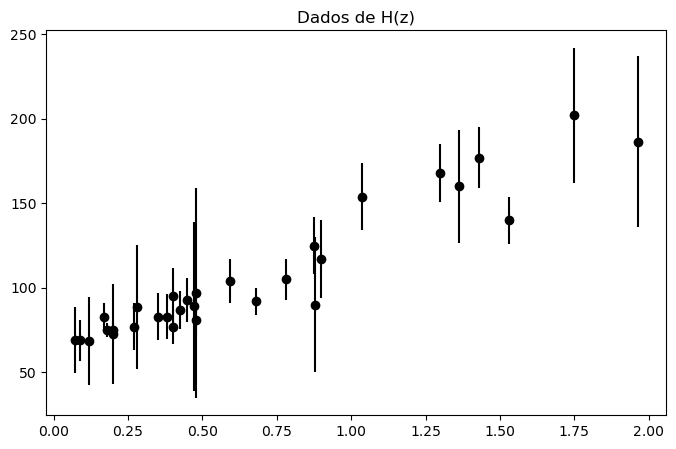

In [6]:
f_x, ax = plt.subplots(1,1, figsize=(8,5))
plt.errorbar(redshift, h, yerr=erro, color='black', fmt="o")
plt.title('Dados de H(z)')

# Gaussian Process Regression

A Gaussian regression process, also known as a regression process with normally distributed errors, is a Bayesian and non-parametric regression method. As such, it aims to establish a relationship among the set of observations capable of obtaining a predictive distribution. This technique has been widely used in the field of observational cosmology to model and analyze astronomical/astrophysical data, allowing for precise estimates of cosmological parameters. 

The algorithmic operation of GPR starts by assuming a prior process, which can be specified using a _mean function_, $m(x)$, and a covariance function $k(x,x')$:

$$
f(x) \sim \mathcal{GP}\left( m(x)\, , \, k(x,x') \right) \,\,\, ,
$$

In this prior process, the collection of training and test points[¹] follows a joint Gaussian distribution, which we can write as:

$$
   \begin{bmatrix}
y \\
f^{}
\end{bmatrix}
\, \sim \, \mathcal{N} \left( \begin{bmatrix}
\mu \\
\mu^{}
\end{bmatrix} \, , \, \begin{bmatrix}
K(X,X)+ \sigma^{2}I & K(X,X^{}) \\
K(X^{},X) & K(X^{},X^{})
\end{bmatrix} \right )
$$

where $K$ is the covariance matrix or _Kernel_, whose entries correspond to the covariance function calculated on the observations, and $I$ is an identity matrix. The form of the mean function and covariance function (also often called kernel) in GPR is chosen and adjusted in the prior process.

o calculate the predictive posterior distribution, the data and test observations are marginalized from the posterior. Choosing a GPR prior to calculate the predictive distribution leads us to a normal distribution described by a mean and a covariance. The predictions are the means of $\bar{f}^{}$, and the variances are obtained from the diagonal of the covariance matrix $\Sigma^{}$.

$$
f^{} , | , X ,  y\, , \, X^{} \, \sim \, \mathcal{N}\left(\bar{f}^{}\, ,\, \Sigma^{} \right)
$$

$$
\bar{f}^{} = \mu^{} + K(X^{*},X)\left[K(X,X)+ \sigma^{2}I \right]^{-1}\left(y-\mu\right)
$$

$$
\Sigma^{} = K(X^{}, X^{}) - K(X^{},X)\left[K(X,X)+ \sigma^{2}I \right]^{-1}K(X,X^{*}) ,,,, .
$$

In the Gaussian regression process carried out, whose curve for $H(z)$ can be visualized in the next plot, it is interesting to note that the value found for the Hubble constant, 
$H_{0}$, was 

$$
H_{0} = 68.09 \pm 1.51 \,\,\, ,
$$ 

which is within the expected range. It is compatible with results from [Planck](https://arxiv.org/abs/1807.06209), where $H_{0}=67.4 \pm 0.5$, and measurements using gravitational waves, the latter being independent of the extragalactic distance scale (distance ladder). More precise measurements using gravitational waves as in [Mukherjee 2020](https://arxiv.org/abs/2009.14199) yield $H_{0} = 67.6^{+4.3}{-4.2}$, and in [Hotokezaka 2018](https://arxiv.org/abs/1806.10596), it obtains $H{0} = 68.9^{+4.7}_{-4.1}$. This indicates that our estimate for $H(z)$ is good and, when used to calculate the gas mass fraction, it will return values that are as model-independent as possible.



In [7]:
# As variáveis para o processo Gaussiano
X = redshift.reshape(n,d)
Y = h

z = np.linspace(redshift.min(),redshift.max(),1000)
X_star = z.reshape(z.shape[0],d)

### Random Search

The kernel function to be used will be a composition of a constant function and an RBF (Radial Basis Function). Therefore, we will have 3 hyperparameters to optimize. We will accomplish this through a random search.

In [8]:
def random_search(X, y, n):
    best_score = -np.inf
    best_params = None

    for _ in range(n):
        # Geração aleatória dos parâmetros
        s1 = np.random.uniform(0.1, 500)
        constant_value_1= np.random.uniform(0.001,500)
        l = np.random.uniform(0.001, 500)

        # Criação do modelo de regressão gaussiana
        kernel = DotP( s1)+ConstantKernel(constant_value=constant_value_1)*RBF(length_scale=l)
        model = GaussianProcessRegressor(kernel=kernel, alpha=10)

        # Ajuste do modelo aos dados
        model.fit(X, y)

        # Avaliação da pontuação (score) do modelo
        score = model.score(X, y)

        # Atualização do melhor score e melhores parâmetros
        if score > best_score:
            best_score = score
            best_params = {'s1': s1, 'C1':constant_value_1, 'l':l}
                          
                           
    return best_params, best_score


In [9]:
# Número de iterações da busca aleatória
n_int = 1500

In [10]:
best_params, best_score = random_search(X, Y, n_int)

print("Melhores parâmetros encontrados:")
print(best_params)

Melhores parâmetros encontrados:
{'s1': 40.744762071779626, 'C1': 5.0941063874535715, 'l': 135.50270634282364}


In [12]:
s1 = best_params['s1']
constant1=best_params['C1']
l = best_params['l']

### Kernel

In [51]:
# Kernel com os melhores valores de C, l e sigma:
GPR_Kernel =DotP(s1)+ConstantKernel(constant1)*RBF(l )


GPR = GaussianProcessRegressor(kernel=GPR_Kernel, alpha=150)

### Fit

In [52]:
GPR.fit(X, Y)

GaussianProcessRegressor(alpha=150,
                         kernel=DotProduct(sigma_0=40.7) + 2.26**2 * RBF(length_scale=136))

### Predição

In [53]:
Y_pred = GPR.predict(X_star)

(0.04000000000000001, 1.995)

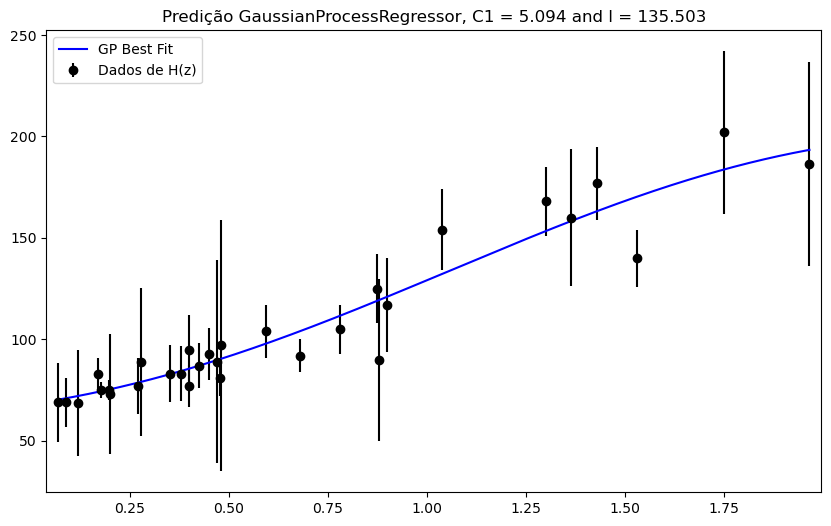

In [54]:
# Feito isso, vamos ver como fica a predição:

fig, ax = plt.subplots(figsize=(10,6))
plt.errorbar(redshift, h, yerr=erro, color='black', label = 'Dados de H(z)', fmt="o")
sns.lineplot(x=z, y=Y_pred, color='blue', label='GP Best Fit', ax=ax)
ax.set(title=f'Predição GaussianProcessRegressor, C1 = {round(constant1,3)} and l = {round(l,3) }')
ax.legend(loc='upper left')
plt.xlim([redshift.min()-0.03,redshift.max()+0.03])

## Plot

In [55]:
# vamos gerar dados no range com uma variância de 1 a 2 std

y_star_samples2 = GPR.sample_y(X_star, n_samples=31)

y_star2 = np.apply_over_axes(func=np.mean, a=y_star_samples2, axes=1).squeeze()

y_star_sd2 = np.apply_over_axes(func=np.std, a=y_star_samples2, axes=1).squeeze()

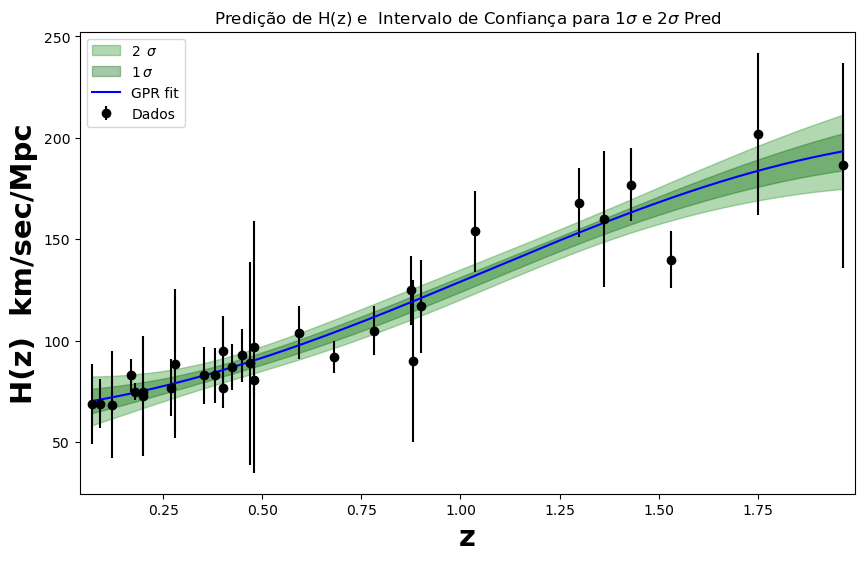

In [56]:
# fazendo o plot

fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(redshift, h, yerr=erro, color='black', label = 'Dados', fmt="o")
ax.fill_between(
    x=z, 
    y1=(y_star2 - 2*y_star_sd2), 
    y2=(y_star2 + 2*y_star_sd2),
    color='green',
    alpha=0.3, 
    label='2 $\, \sigma $'
)
ax.fill_between(
    x=z, 
    y1=(y_star2 - y_star_sd2), 
    y2=(y_star2 + y_star_sd2),
    color='darkgreen',
    alpha=0.35, 
    label='1$\, \sigma $'
)
sns.lineplot(x=z, y=Y_pred, color='blue', label='GPR fit')
ax.set(title='Predição de H(z) e  Intervalo de Confiança para 1$\sigma$ e 2$\sigma$ Pred')
ax.legend(loc='upper left')
plt.xlabel('z', fontsize=21, fontweight='bold')
plt.ylabel('H(z)  km/sec/Mpc', fontsize=21, fontweight='bold')
plt.xlim([redshift.min()-0.03,redshift.max()+0.03])
plt.savefig('H(z)-GaussianProcess15.png')

In [57]:
def H_GPR(z):
    '''
    H_GPR vai receber um inteiro/float ou uma lista com valor(es) de redshift
    e retornar o valor estimado de H(z) usando Gaussian Process Regression
    '''
    
    if type(z) == int or type(z) == float:
        p = [z]
        p = np.array(p)
        p = p.reshape(p.shape[0],1)
        h = GPR.predict(p)
        h.reshape(1)
    else:
        z = np.array(z)
        z = z.reshape(z.shape[0],1)
        h = GPR.predict(z)
        #h.reshape(1)
    
    h = np.round(h,2)
    
    return h

# Resultado do GPR para os dados de H(z):

Assim podemos estimar $H_{0}$ e usar o GPR do H(z) para calcular a distância de diâmetro angular $d_{A}$ de maneira independente de modelo. Nossa estimativa obtida para $H_{0}$ usando GPR foi de:

$$
68.09 \pm 1.51
$$

In [58]:
H_0 = H_GPR([0])
erro_medio = np.std(y_star_sd2)
print(H_0,',' ,round(erro_medio,2))

[68.09] , 1.51
